# IPLBot-RASA

# Como construir e fazer deploy de um Chatbot utilizando Rasa (utilizando estudo de caso IPL)

Entendendo um pouco da estrutura do nosso chatbot

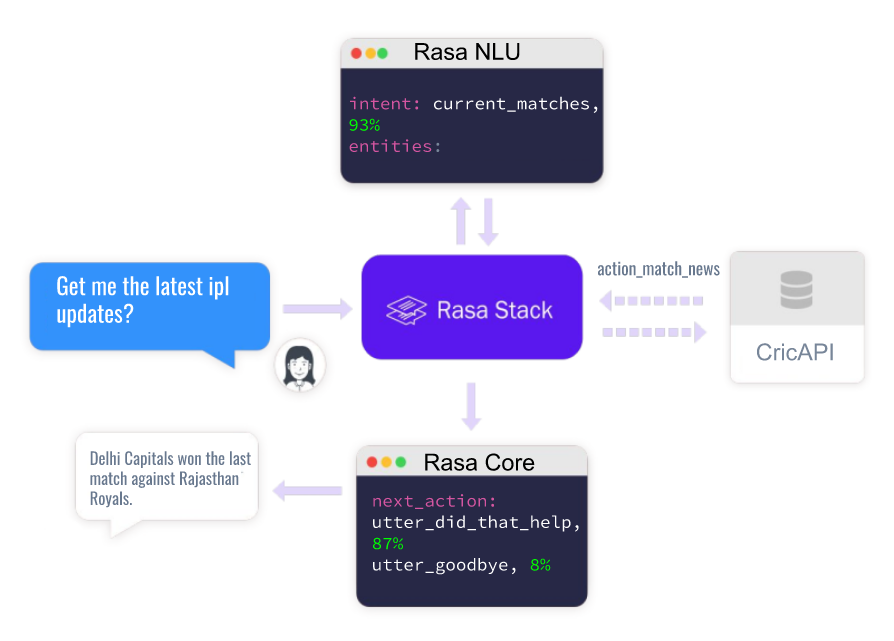